## Base code of timeseries classification using Keras
### using the same code of "https://keras.io/examples/timeseries/timeseries_classification_from_scratch/"

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import sklearn
import sklearn.metrics.pairwise

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

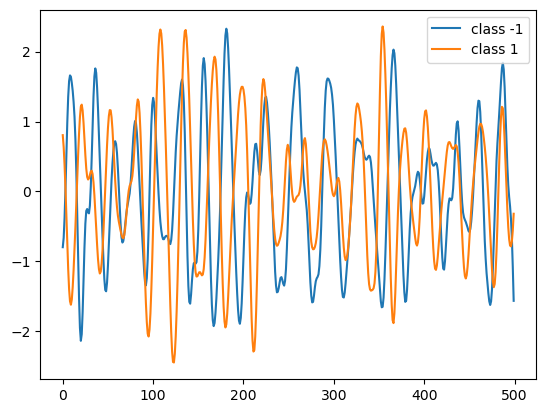

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [4]:
# eps:閾値の範囲. 2点間のy座標の差をeps刻みで評価する.
# steps:画素値の種類.

def RP_generate(s, eps=None, steps=None):
    if eps==None: eps=0.1   # 閾値
    if steps==None: steps=10   # 閾値を何段階設定するか
    d = sklearn.metrics.pairwise.pairwise_distances(s)   # 距離行列
    d = np.floor(d / eps)   # Unthresholded Recurrence Plot
    d[d > steps] = steps
    d_steps = steps * np.ones(d.shape)
    d_re = d_steps - d   # 閾値内に入った時に点をプロットするような仕様に変更
    return d_re

In [5]:
# 10値リカレンスプロット:eps=0.1, steps=10
eps = 0.1
steps = 10
RP_size = 128

X_train = np.zeros((x_train.shape[0], RP_size, RP_size))
for ii in range(x_train.shape[0]):
  ts = x_train[ii,:]
  X_train[ii, :, :] = resize(RP_generate(ts[:,None],eps,steps), (RP_size, RP_size), mode = 'constant')
  if ii % int(x_train.shape[0]/10) == 0:
    print('Status : %d ％' % int((ii+1)/x_train.shape[0]*100))

Status : 0 ％
Status : 10 ％
Status : 20 ％
Status : 30 ％
Status : 40 ％
Status : 50 ％
Status : 60 ％
Status : 70 ％
Status : 80 ％
Status : 90 ％
Status : 100 ％


In [6]:
X_test = np.zeros((x_test.shape[0], RP_size, RP_size))
for ii in range(x_test.shape[0]):
  ts = x_test[ii,:]
  X_test[ii, :, :] = resize(RP_generate(ts[:,None],eps,steps), (RP_size, RP_size), mode = 'constant')
  if ii % int(x_test.shape[0]/10) == 0:
    print('Status : %d ％' % int((ii+1)/x_test.shape[0]*100))

Status : 0 ％
Status : 10 ％
Status : 20 ％
Status : 30 ％
Status : 40 ％
Status : 50 ％
Status : 60 ％
Status : 70 ％
Status : 80 ％
Status : 90 ％


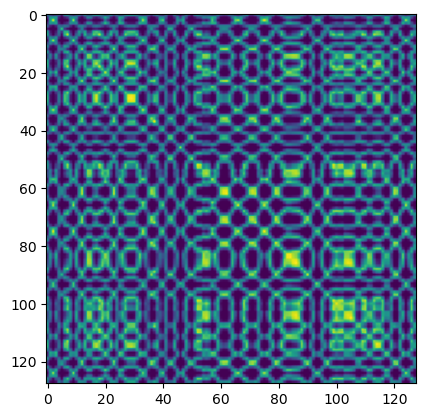

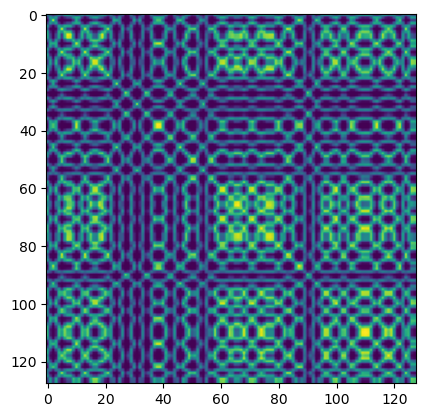

In [7]:
for c in classes:
    plt.figure()
    c_X_train = X_train[y_train == c,:,:]
    plt.imshow(c_X_train[0], label="class " + str(c))
    plt.show()
    plt.close()

In [8]:
# 正規化
X_train = np.array((X_train - X_train.min()) / X_train.max(), dtype=np.float32)

In [9]:
# モデルがデータを読み込むには事前にunsqueeze的な作業が必要
X_train = X_train.reshape(X_train.shape[0], 1, RP_size, RP_size)
X_test = X_test.reshape(X_test.shape[0], 1, RP_size, RP_size)

In [10]:
num_classes = len(np.unique(y_train))

In [11]:
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [12]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [13]:
batch_size = 32   # バッチサイズ
num_epochs = 500  # エポック数
filters1 = 64
filters2 = 64
kernel = 3
slide = 2
dropout1 = 0.25
dropout2 = 0.25
dropout3 = 0.5
dense = 64

In [14]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv2D(filters1, (kernel,kernel), activation='relu', data_format='channels_first')(input_layer)
    conv1 = keras.layers.MaxPooling2D(slide,slide)(conv1)
    conv1 = keras.layers.Dropout(dropout1)(conv1)

    conv2 = keras.layers.Conv2D(filters2, (kernel,kernel), activation='relu')(conv1)
    conv2 = keras.layers.MaxPooling2D(slide,slide)(conv2)
    conv2 = keras.layers.Dropout(dropout2)(conv2)
    conv2 = keras.layers.Flatten()(conv2)

    conv3 = keras.layers.Dense(dense, activation='relu')(conv2)
    conv3 = keras.layers.Dropout(dropout3)(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(conv3)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 5s 33ms/step - loss: 0.7306 - sparse_categorical_accuracy: 0.5066 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.4938
Epoch 2/500
90/90 [==============================] - 3s 31ms/step - loss: 0.6927 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.6937 - val_sparse_categorical_accuracy: 0.4938
Epoch 3/500
90/90 [==============================] - 3s 31ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.5111 - val_loss: 0.6941 - val_sparse_categorical_accuracy: 0.4938
Epoch 4/500
90/90 [==============================] - 3s 31ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.6942 - val_sparse_categorical_accuracy: 0.4938
Epoch 5/500
90/90 [==============================] - 3s 31ms/step - loss: 0.6929 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.6941 - val_sparse_categorical_accuracy: 0.4938
Epoch 6/500
90/90 [==============================] - 3s 31ms/step - loss: 0.6926 - sparse_categorica

In [16]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 12ms/step - loss: 15.2899 - sparse_categorical_accuracy: 0.4955
Test accuracy 0.4954545497894287
Test loss 15.289912223815918


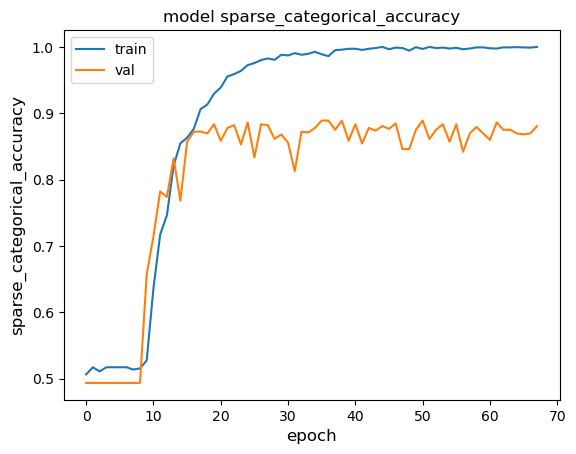

In [17]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

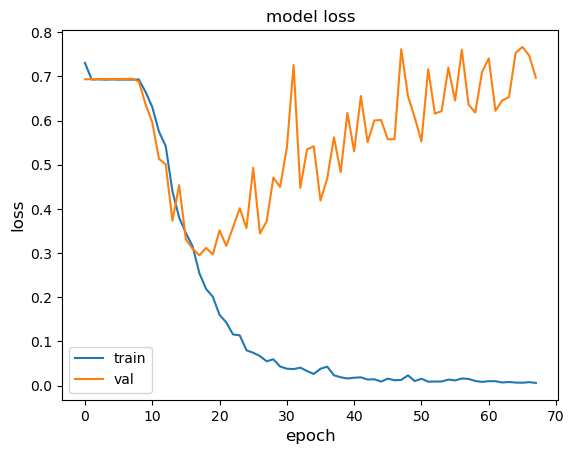

In [18]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()